In [1]:
import pandas as pd
dating = pd.read_csv("profiles.csv")

In [2]:
# basic data cleanup
# income
dating.loc[dating["income"] == -1, "income"] = pd.NA

# Let's create ML algorithm that will predict drug use on empty fields

prepare data some more for drug investigation

In [3]:
# create some suspicios words list that may relate to drug use to filter from essays
drug_words = ["party", "fun", "hang out", "festival", "good time", "drink"]
essay_cols = [col for col in dating.columns if col.startswith("essay")]
for word in drug_words:
    dating[word + "_count"] = dating[essay_cols].apply(
        lambda row: sum(str(cell).lower().count(word) for cell in row if pd.notna(cell)),
        axis=1
    )
    
dating = dating.drop(columns=essay_cols)

Prepare data for machine learning

In [4]:
drugs_values = dating["drugs"].value_counts()
dating_drugs_filled = dating.dropna(subset=["drugs"])
dating_drugs_missing = dating[dating["drugs"].isna()]
features = dating_drugs_filled.drop(columns=["drugs"])
labels = dating_drugs_filled["drugs"]
features["education"][features["education"].str.contains("graduated", na=False)].value_counts()
features["religion"].value_counts()
labels.value_counts(normalize=True)

drugs
never        0.822483
sometimes    0.168578
often        0.008939
Name: proportion, dtype: float64

In [5]:
# prepare features for ML
features = pd.get_dummies(features, columns=["body_type", "drinks", "job", "orientation", "pets"], dummy_na=False)

from tools import bucket_education, is_strict_diet

# extract most common single ethnicities (about 5), rest as "other"
# literal list based on value_counts and inspection
ethnicities = [
    "white",
    "asian",
    "black",
    "hispanic / latin",
    "other",
    "middle eastern",
    "native american",
    "pacific islander",
    "indian"
]
for ethn in ethnicities:
    features[ethn] = features["ethnicity"].apply(lambda val: True if pd.notna(val) and ethn in val else False)

features["education_bucket"] = features["education"].apply(bucket_education)
features = pd.get_dummies(features, columns=["education_bucket"], dummy_na=False)
features["male"] = features["sex"].apply(lambda val: True if val == "m" else False)
features["smokes"] = features["smokes"].apply(lambda val: False if val == "no" else True)
features["is_single"] = features["status"].apply(lambda val: True if val == "single" else False)
features["has_kid_s"] = features["offspring"].apply(lambda val: True if pd.notna(val) and "has" in val else False)
features["strict_diet"] = features["diet"].apply(is_strict_diet)
features["strict_religion"] = features["religion"].apply(lambda val: True if pd.notna(val) and "very serious about it" in val else False)
diets = ["vegan", "vegetarian", "halal", "kosher"]
for diet in diets:
    features[diet] = features["diet"].apply(lambda val: True if pd.notna(val) and diet in val else False)

features = features.select_dtypes(include=["number", "bool"])

In [6]:
education_unique = dating["education"].dropna().unique()
education_buckets = {edu: bucket_education(edu) for edu in education_unique}
education_buckets

{'working on college/university': 'high_school',
 'working on space camp': 'lower',
 'graduated from masters program': 'graduated',
 'graduated from college/university': 'graduated',
 'working on two-year college': 'high_school',
 'graduated from high school': 'high_school',
 'working on masters program': 'high_school',
 'graduated from space camp': 'high_school',
 'college/university': 'graduated',
 'dropped out of space camp': 'lower',
 'graduated from ph.d program': 'Ph.D',
 'graduated from law school': 'high_school',
 'working on ph.d program': 'graduated',
 'two-year college': 'graduated',
 'graduated from two-year college': 'graduated',
 'working on med school': 'lower',
 'dropped out of college/university': 'high_school',
 'space camp': 'high_school',
 'graduated from med school': 'high_school',
 'dropped out of high school': 'lower',
 'working on high school': 'lower',
 'masters program': 'graduated',
 'dropped out of ph.d program': 'graduated',
 'dropped out of two-year colleg

let's go with decision tree model

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=21)
dtree = DecisionTreeClassifier(class_weight="balanced", max_depth=10, random_state=10)
dtree.fit(x_train, y_train)
tree_text = tree.export_text(dtree, feature_names=list(x_train.columns))
print(tree_text)

|--- smokes <= 0.50
|   |--- income <= 375000.00
|   |   |--- orientation_bisexual <= 0.50
|   |   |   |--- drinks_often <= 0.50
|   |   |   |   |--- age <= 27.50
|   |   |   |   |   |--- education_bucket_graduated <= 0.50
|   |   |   |   |   |   |--- job_artistic / musical / writer <= 0.50
|   |   |   |   |   |   |   |--- drinks_socially <= 0.50
|   |   |   |   |   |   |   |   |--- education_bucket_high_school <= 0.50
|   |   |   |   |   |   |   |   |   |--- height <= 70.50
|   |   |   |   |   |   |   |   |   |   |--- class: never
|   |   |   |   |   |   |   |   |   |--- height >  70.50
|   |   |   |   |   |   |   |   |   |   |--- class: often
|   |   |   |   |   |   |   |   |--- education_bucket_high_school >  0.50
|   |   |   |   |   |   |   |   |   |--- drink_count <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: never
|   |   |   |   |   |   |   |   |   |--- drink_count >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: often
|   |   |   |   |   |   |   |--- dr

In [8]:
from sklearn.metrics import classification_report
from tools import get_report

get_report(dtree, x_test, y_test)

Macro-F1: 0.7376968172674336
0.7483778715815311
              precision    recall  f1-score   support

       never       0.91      0.76      0.83      7528
   sometimes       0.35      0.49      0.41      1563
       often       0.05      0.42      0.09        83

    accuracy                           0.71      9174
   macro avg       0.44      0.56      0.44      9174
weighted avg       0.81      0.71      0.75      9174

              precision    recall  f1-score   support

       never       0.91      0.76      0.83      7528
   sometimes       0.35      0.49      0.41      1563
       often       0.05      0.42      0.09        83

    accuracy                           0.71      9174
   macro avg       0.44      0.56      0.44      9174
weighted avg       0.81      0.71      0.75      9174



We see very poor performance by the decision tree model.
Let's try something, that takes in account the ordinality of labels.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
ord_map = {'never': 0, 'sometimes': 1, 'often': 2}
labels = labels.map(ord_map)
scaler = StandardScaler()
imputer = SimpleImputer(strategy="median")
# Apply scaler only to int and float columns
num_cols = features.select_dtypes(include=["int", "float"]).columns
features[num_cols] = scaler.fit_transform(features[num_cols])
features[num_cols] = imputer.fit_transform(features[num_cols])
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=.2, random_state=21)
log_regressor = LogisticRegression(random_state=10, max_iter=1000)
log_regressor.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=10)

Not thresholded:
Macro-F1: 0.8098505000957094
0.8081334687746531
              precision    recall  f1-score   support

       never       0.86      0.97      0.91      7528
   sometimes       0.58      0.26      0.36      1563
       often       0.33      0.02      0.04        83

    accuracy                           0.84      9174
   macro avg       0.59      0.42      0.44      9174
weighted avg       0.81      0.84      0.81      9174

Macro-F1: 0.8098505000957094
0.8081334687746531
              precision    recall  f1-score   support

       never       0.86      0.97      0.91      7528
   sometimes       0.58      0.26      0.36      1563
       often       0.33      0.02      0.04        83

    accuracy                           0.84      9174
   macro avg       0.59      0.42      0.44      9174
weighted avg       0.81      0.84      0.81      9174



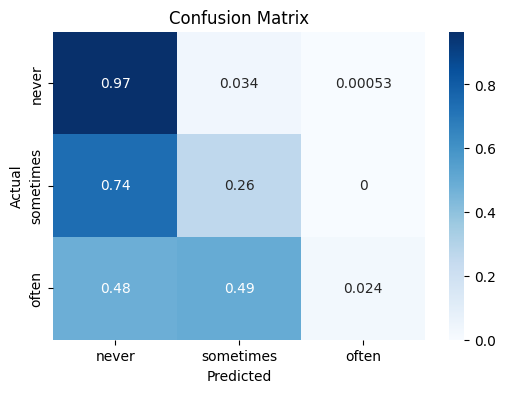

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# evaluate performance
y_pred = log_regressor.predict(x_test)
print("Not thresholded:")
get_report(log_regressor, x_test, y_test)
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

still far from working model, let's try custom thresholding to improve the predictions

Best 'often' thresh: 0.09896755439047003 F1_often: 0.24581005586542443
Best 'sometimes' thresh: 0.2382997131172823 F1_sometimes: 0.5107451855981718
Thresholded: 
0.8099827987151159
              precision    recall  f1-score   support

       never       0.91      0.85      0.88      7528
   sometimes       0.44      0.58      0.50      1563
       often       0.22      0.25      0.24        83

    accuracy                           0.80      9174
   macro avg       0.53      0.56      0.54      9174
weighted avg       0.83      0.80      0.81      9174



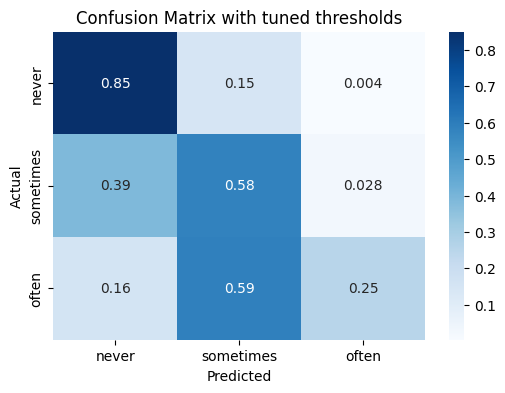

In [11]:
from tools import get_best_thresholds, predict_with_thresholds
from sklearn.metrics import f1_score

# 1) Get predicted probabilities on a hold-out (validation) set
probs = log_regressor.predict_proba(x_test)  
# probs[:,0] = P(never), probs[:,1]=P(sometimes), probs[:,2]=P(often)

t_opt_o, t_opt_s = get_best_thresholds(probs, y_test)

y_pred_thr = predict_with_thresholds(probs, t_opt_o, t_opt_s)

print("Thresholded: ")
print(f1_score(y_test, y_pred_thr, average="weighted"))

unique_labels = y_test.value_counts().index.tolist()
print(
    classification_report(
        y_test,
        y_pred_thr,
        labels=unique_labels,
        target_names=["never", "sometimes", "often"],
        zero_division=0,  # avoid ‘undefined’ warnings if a class is missing
    )
)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds')
plt.show()

That helped quite a bit, but still the prediction for sometimes and often is not great. Due to low count of observations, we might not get better no matter what.

Let's see if oversampling the minority class within model will help.

from imblearn.over_sampling import SMOTENC

# Identify which feature indices are truly categorical/boolean
cat_idxs = [x_train.columns.get_loc(c) for c in x_train.columns if c not in num_cols]

smote_nc = SMOTENC(
    categorical_features=cat_idxs,
    random_state=42
)

x_res, y_res = smote_nc.fit_resample(x_train, y_train)
log_regressor_ovsamp = LogisticRegression(random_state=10, max_iter=1000)
log_regressor_ovsamp.fit(x_res, y_res)

get_report(log_regressor_ovsamp, x_test, y_test)
# 5) Evaluate on your test set
probs_test = log_regressor_ovsamp.predict_proba(x_test)
y_pred_thr = predict_with_thresholds(probs_test, t_opt_o, t_opt_s)

print("Thresholded: ")
print(f1_score(y_test, y_pred_thr, average="weighted"))

unique_labels = y_test.value_counts().index.tolist()
print(
    classification_report(
        y_test,
        y_pred_thr,
        labels=unique_labels,
        target_names=["never", "sometimes", "often"],
        zero_division=0,  # avoid ‘undefined’ warnings if a class is missing
    )
)


cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and oversampling')
plt.show()

that really did not help as we significantly worsened the predictions for "never" class without really improving the minority classes predictions

Let's try one last thing - tune bias - C - to see if that helps.

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]}
log_reg = LogisticRegression(random_state=10, max_iter=1000)
grid = GridSearchCV(log_reg, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
grid.fit(x_train, y_train)

print("Best C:", grid.best_params_['C'])
print("Best CV score:", grid.best_score_)

Best C: 10
Best CV score: 0.8132382045987564


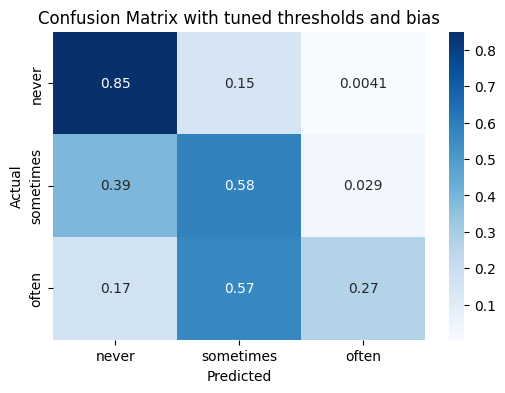

In [13]:
probs_test = grid.predict_proba(x_test)
y_pred_thr = predict_with_thresholds(probs_test, t_opt_o, t_opt_s)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and bias')
plt.show()

reduce features if that will have effect

In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model      import LogisticRegression

# 1) pick your “estimator” for ranking features
base_clf = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    C=1.0,
    max_iter=2000,
    random_state=42
)

# 2) set up RFE to keep, say, the top 30 features
rfe = RFE(
    estimator=base_clf,
    n_features_to_select=30,
    step=5,           # remove 5 features per iteration
)

# 3) fit only on train
rfe.fit(x_train, y_train)

# 4) transform your sets
x_train_rfe = rfe.transform(x_train)
x_test_rfe  = rfe.transform(x_test)

print("Kept features:", x_train_rfe.shape[1])
kept_feature_names = [x_train.columns[i] for i, keep in enumerate(rfe.support_) if keep]
print("Kept feature names:", kept_feature_names)

# 5) retrain or tune C on the reduced set
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import make_scorer, f1_score

param_grid = {"C": [1, 2, 5, 10, 15, 20, 50, 100]}
grid = GridSearchCV(
    LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ),
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average="weighted", zero_division=0),
    cv=5,
    n_jobs=-1
)
grid.fit(x_train_rfe, y_train)

print("Best C:", grid.best_params_["C"])
print("CV Macro-F1:", grid.best_score_)

Kept features: 30
Kept feature names: ['age', 'smokes', 'body_type_jacked', 'body_type_overweight', 'body_type_rather not say', 'body_type_skinny', 'body_type_used up', 'drinks_desperately', 'drinks_often', 'drinks_rarely', 'drinks_socially', 'drinks_very often', 'job_artistic / musical / writer', 'job_military', 'job_rather not say', 'job_retired', 'job_unemployed', 'orientation_gay', 'orientation_straight', 'pets_dislikes dogs', 'pets_dislikes dogs and likes cats', 'pets_has cats', 'pets_likes cats', 'indian', 'education_bucket_lower', 'is_single', 'strict_diet', 'strict_religion', 'halal', 'kosher']
Best C: 10
CV Macro-F1: 0.8020393172915379
Best C: 10
CV Macro-F1: 0.8020393172915379


Best 'often' thresh: 0.06780274816280982 F1_often: 0.20083682008322867
Best 'sometimes' thresh: 0.2080329188806009 F1_sometimes: 0.4814910691167926


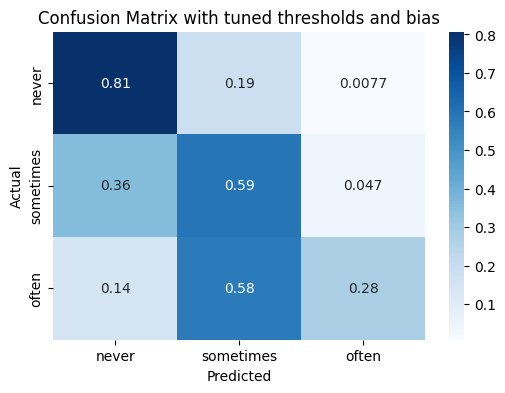

In [15]:
probs_test = grid.predict_proba(x_test_rfe)
t_opt_o, t_opt_s = get_best_thresholds(probs=probs_test, y_test=y_test)
y_pred_thr = predict_with_thresholds(probs_test, t_opt_o, t_opt_s)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=['never', 'sometimes', 'often'], yticklabels=['never', 'sometimes', 'often'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and bias')
plt.show()

finally, let's try just binary classification - drugs or not - if we can get better

In [16]:
labels_binary = (labels != 0)
x_train, x_test, y_train, y_test = train_test_split(features, labels_binary, test_size=.2, random_state=21)

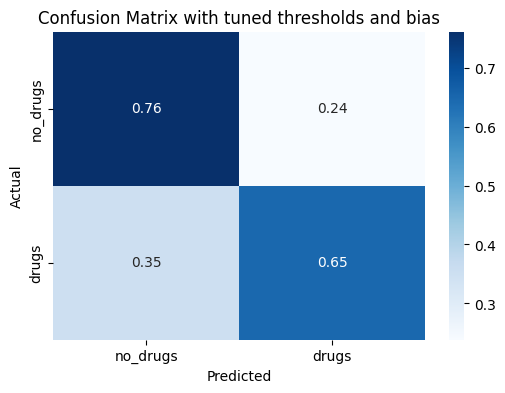

In [17]:
dtree = DecisionTreeClassifier(class_weight="balanced", max_depth=10, random_state=10)
dtree.fit(x_train, y_train)
tree_text = tree.export_text(dtree, feature_names=list(x_train.columns))

cm = confusion_matrix(y_test, dtree.predict(x_test), normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and bias')
plt.show()

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model      import LogisticRegression
from tools import get_best_thresh_binary
import numpy as np

# 1) pick your “estimator” for ranking features
base_clf = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    C=1.0,
    max_iter=2000,
    random_state=42
)

# 2) set up RFE to keep, say, the top 30 features
rfe = RFE(
    estimator=base_clf,
    n_features_to_select=30,
    step=5,           # remove 5 features per iteration
)

# 3) fit only on train
rfe.fit(x_train, y_train)

# 4) transform your sets
x_train_rfe = rfe.transform(x_train)
x_test_rfe  = rfe.transform(x_test)

print("Kept features:", x_train_rfe.shape[1])
kept_feature_names = [x_train.columns[i] for i, keep in enumerate(rfe.support_) if keep]
print("Kept feature names:", kept_feature_names)

# 5) retrain or tune C on the reduced set
from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import make_scorer, f1_score

param_grid = {"C": [1, 2, 5, 10, 15, 20, 50, 100]}
grid = GridSearchCV(
    LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=42
    ),
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average="weighted", zero_division=0),
    cv=5,
    n_jobs=-1
)
grid.fit(x_train_rfe, y_train)



Kept features: 30
Kept feature names: ['smokes', 'body_type_used up', 'drinks_desperately', 'drinks_often', 'drinks_rarely', 'drinks_socially', 'drinks_very often', 'job_artistic / musical / writer', 'job_banking / financial / real estate', 'job_executive / management', 'job_law / legal services', 'job_medicine / health', 'job_military', 'job_transportation', 'job_unemployed', 'orientation_gay', 'orientation_straight', 'pets_dislikes dogs and likes cats', 'pets_has cats', 'pets_has dogs and likes cats', 'pets_likes cats', 'pets_likes dogs and has cats', 'pets_likes dogs and likes cats', 'indian', 'education_bucket_lower', 'male', 'is_single', 'vegan', 'vegetarian', 'halal']


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1, param_grid={'C': [1, 2, 5, 10, 15, 20, 50, 100]},
             scoring=make_scorer(f1_score, response_method='predict', average=weighted, zero_division=0))

Best threshold: 0.22685579232567596, F1: 0.524498603706038


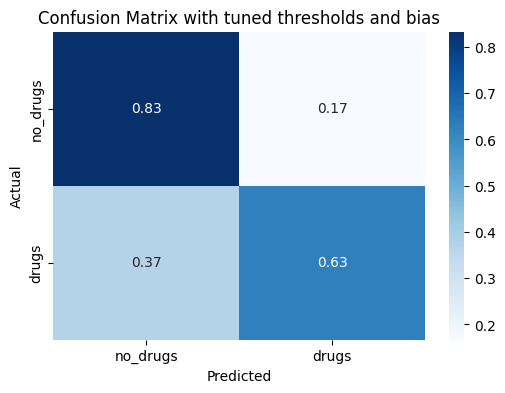

In [23]:
best_thr = get_best_thresh_binary(grid.predict_proba(x_test_rfe)[:, 1], y_test)
y_pred_thr = (grid.predict_proba(x_test_rfe)[:, 1] >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_thr, normalize="true")
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', xticklabels=["no_drugs", "drugs"], yticklabels=["no_drugs", "drugs"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with tuned thresholds and bias')
plt.show()

last, let's try some hyperparameter tuning for dtree